In [47]:
import math
from typing import List, Tuple


class Value:
    def __init__(
        self, data: float|int = 0.0, _children: tuple = (), _op: str = "", label: str = ""
    ) -> None:
        self.data: float = data
        self.grad: float = 0.0
        self._backward = lambda: None
        self._prev: set = set(_children)
        self._op: str = _op
        self.label: str = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other) -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward() -> None:
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward() -> None:
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Exponent must be an int or float"
        out = Value(self.data**other,(self,),f"**{other}")
        def _backward():
            self.grad +=other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out
            
        
    
    def __rmul__(self, other): # self*other
        return self*other
    
    def __truediv__(self, other): # self/other
        return self * other**-1
    
    def __neg__(self):
        return -1*self
    
    def __sub__(self, other):
        return self + (-other)
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward() -> None:
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        
        def _backward() -> None:
            self.grad += out.data * out.grad
        out.grad = _backward
        return out
    
    
    
    
    def backward(self) -> None:
        topo : List[Value] = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
        
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
        

In [48]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [49]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

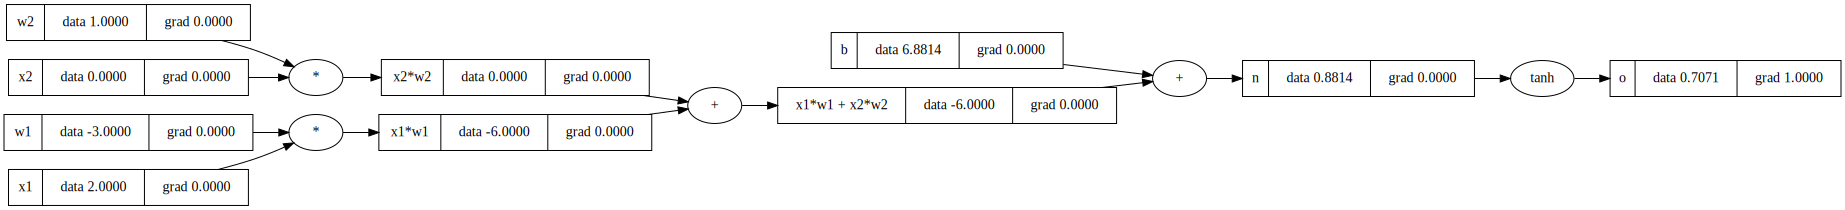

In [50]:
draw_dot(o)

In [51]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

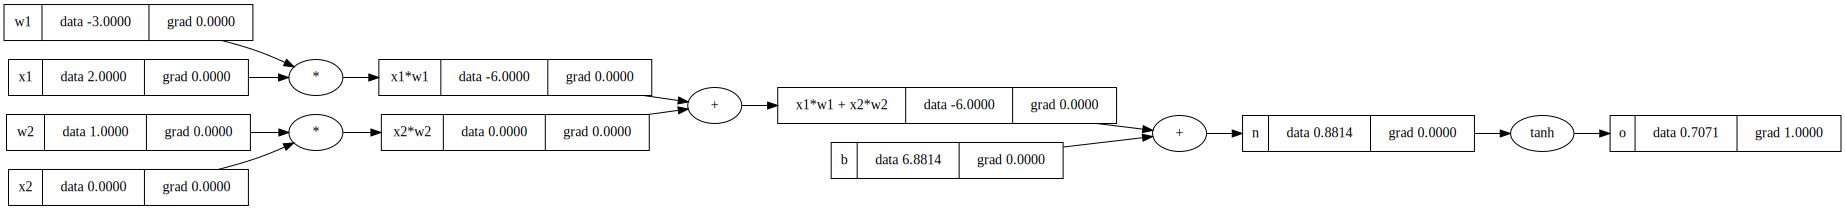

In [52]:
draw_dot(o)